This notebook is exploring using Facebook Prophet while also trying to determine when to retrain the model using the volatility measurement inspired by the DRAIN service

In [30]:
from prophet import Prophet
import pandas as pd
from datetime import datetime, timedelta
import altair as alt
from collections import deque
import numpy as np
import math
import time

fit_predict_model is a function which will take in a dataframe, fit the Prophet model to it and then give the forecasted results back for the next N minutes

In [31]:
def fit_predict_model(dataframe,periods=15,changepoint_prior_scale=0.10,daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False):
    prophet_model = Prophet(growth="logistic",changepoint_prior_scale=changepoint_prior_scale,daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality, yearly_seasonality=yearly_seasonality)
    prophet_model.fit(dataframe)
    future = prophet_model.make_future_dataframe(periods=periods,freq="1MIN",include_history=False,)
    future["cap"] = 1.0
    future_forecast = prophet_model.predict(future)
    future_forecast["timestamp"] = future_forecast["ds"]
    future_forecast = future_forecast.set_index("timestamp")
    return future_forecast

detect_anomalies determines if each of the actual values is within the lower and upper bound.

In [32]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact', 'upper_std', 'lower_std']].copy()
    #forecast['fact'] = df['y']
    forecasted.loc[forecasted['fact'] > forecasted['upper_std'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['lower_std'], 'anomaly'] = 1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

plot_anomalies is a function that will plot the lower and upper bounds for each data point in addition to the actual value. Anomalies are marked by red meaning the data point is outside of the lower and upper bound range.

In [33]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T', axis=alt.Axis(format='%H:%M'), title ='date'),
    y='upper_std',
    y2='lower_std',
    tooltip=['ds', 'fact', 'lower_std', 'upper_std']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'lower_std', 'upper_std']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'lower_std', 'upper_std']
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

Read in 600 data points from clusterwide_cpu_usage_percentage.txt which contains 600 minutes worth of CPU usage within a cluster

In [34]:
dataset_values = []
date_time_vals = []
with open('clusterwide_cpu_usage_percentage.txt','r') as cmd:
    for line in cmd:
        line = line.rstrip().split(",")
        date_time = datetime.fromtimestamp(float(line[0]))
        date_time_vals.append(float(line[0]))
        metric_dict = {"ds": date_time.strftime("%Y-%m-%d %H:%M:%S"), "y": float(line[1]) / 100.0}
        dataset_values.append(metric_dict)

Inject some outlier data at the end of this dataset to see whether or not these data points are marked as an anomaly or if model can adjust its forecasts over time

In [35]:
last_one = date_time_vals[-1] + 60
icr = 0.70
for i in range(500):
    if i % 50 == 0:
        icr += 0.01
    new_dict = {"ds": (datetime.fromtimestamp(last_one)).strftime("%Y-%m-%d %H:%M:%S"), "y": icr}
    last_one += 60
    dataset_values.append(new_dict)
    

Define data_range to determine how much of the dataset you would want to work with

In [36]:
data_range = 1200

Define time_interval for how often FB Prophet model will be retrained.

In [37]:
time_interval = 15

Define the maximum amount of training data which the FB prophet model will be trained on

In [38]:
training_metric_limit = 1440

Define the changepoint_range for the Prophet model

In [39]:
changepoint_prior_scale = 0.05

Retrieve the first data_range values of the dataset

In [40]:
data_values = dataset_values[:data_range]

For the initial training of the FB Prophet model, retrieve the first time_interval data points from the dataset

In [41]:
training_dataset = data_values[:time_interval]

Turn the training_dataset list into a Pandas dataframe so it can be taken as input into Prophet model

In [42]:
training_dataset_df = pd.DataFrame(training_dataset)

weighted_avg_and_std function which computes the weighted mean and standard deviation of a numpy array.

In [43]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average) ** 2, weights=weights)
    return average, math.sqrt(variance)

Initial variables declaration

In [44]:
metrics_data_queue = deque([],training_metric_limit)
normal_periods = []
num_anomalies = 0
metric_data_obtained = dict()
column_names =  ['trend', 'yhat', 'yhat_lower', 'yhat_upper']
train_on_next_chance = True
stable = False
training_start_ts_ns = 0
very_first_ts_ns = 0
forecasting_future = 1000
future_forecast = None
metrics_db = dict()
prediction_results = []
weighted_vols = []

In [45]:
%%time
for i in range(0,len(data_values)):
    metric_data_obtained = dict()
    current_metric_datetime = data_values[i]["ds"]
    element = datetime.strptime(current_metric_datetime,"%Y-%m-%d %H:%M:%S")
    element_datetime_tuple = element.timetuple()
    current_ts = int(time.mktime(element_datetime_tuple))
    if training_start_ts_ns == 0:
        training_start_ts_ns = current_ts
        very_first_ts_ns = current_ts
    current_metric_value = data_values[i]["y"]
    metrics_db[current_ts] = data_values[i]
    metrics_data_queue.appendleft(current_metric_value)
    cumulative_metrics_data = np.array(metrics_data_queue)
    vol = np.std(cumulative_metrics_data) / np.mean(cumulative_metrics_data[:10])
    time_steps = cumulative_metrics_data.shape[0]
    weights = np.flip(np.true_divide(np.arange(1, time_steps + 1), time_steps))
    weighted_mean, weighted_std = weighted_avg_and_std(cumulative_metrics_data, weights)
    weighted_vol = weighted_std / np.mean(cumulative_metrics_data[:10])
    weighted_vols.append(weighted_vol)
    if future_forecast is not None:
        nearest_index = future_forecast.index.get_loc(current_metric_datetime, method="nearest")
        nearest_index_value = future_forecast.iloc[[nearest_index]]
        for c in column_names:
            metric_data_obtained[c] = nearest_index_value[c].values[0]
        yhat_lower = nearest_index_value['yhat_lower'].values[0]
        yhat_upper = nearest_index_value['yhat_upper'].values[0]
        yhat_value = nearest_index_value['yhat'].values[0]
        yhat_lower = max(0, yhat_lower)
        upper_std = abs(yhat_upper - yhat_value)
        lower_std = abs(yhat_value - yhat_lower)
        metric_data_obtained = {"fact": current_metric_value, "ds": current_metric_datetime}
        metric_data_obtained['lower_std'] = max(0, yhat_lower - 2 * lower_std)
        metric_data_obtained['upper_std'] = yhat_upper + (2 * upper_std)
        metric_data_obtained['yhat_lower'] = yhat_lower
        metric_data_obtained['yhat_upper'] = yhat_upper
        metric_data_obtained['anomaly'] = 0
        if (current_metric_value < yhat_lower - (2 * lower_std)) or (current_metric_value > yhat_upper + (2 * upper_std)):
            metric_data_obtained['anomaly'] = 1
            num_anomalies += 1
        prediction_results.append(metric_data_obtained)
        
    if len(metrics_data_queue) > 15:
        if weighted_vol >= 0.199:
            train_on_next_chance = True

        if (weighted_vol < 0.199 and training_start_ts_ns != very_first_ts_ns and train_on_next_chance):
            training_start_ts_ns = current_ts

        if weighted_vol > 0.155 and not train_on_next_chance and stable:
            training_end_ts_ns = current_ts
            normal_periods.append({"start_ts": training_start_ts_ns, "end_ts": training_end_ts_ns})
            stable = False
            training_start_ts_ns = -1.0

        if weighted_vol <= 0.15 and train_on_next_chance:
            print(f"SENDING TRAIN SIGNAL on iteration {i}")
            if training_start_ts_ns != -1.0:
                training_end_ts_ns = current_ts
                normal_periods.append({"start_ts": training_start_ts_ns, "end_ts": training_end_ts_ns})
            train_on_next_chance = False
            stable = True
            training_start_ts_ns = current_ts
            training_ds = []
            for normal in normal_periods:
                start_ts, end_ts = normal["start_ts"], normal["end_ts"]
                print(start_ts)
                print(end_ts)
                print(metrics_db)
                for ts in range(start_ts,end_ts,60):
                    if ts in metrics_db:
                        training_ds.append(metrics_db[ts])
            training_ds_df = pd.DataFrame(training_ds)
            training_ds_df['cap'] = 1.0
            print(training_ds_df)
            future_forecast = fit_predict_model(training_ds_df,periods=training_metric_limit)


INFO:prophet:n_changepoints greater than number of observations. Using 5.


SENDING TRAIN SIGNAL on iteration 15
1626463022
1626463923
{1626463022: {'ds': '2021-07-16 15:17:02', 'y': 0.1728020833333479}, 1626463082: {'ds': '2021-07-16 15:18:02', 'y': 0.1532187500000266}, 1626463142: {'ds': '2021-07-16 15:19:02', 'y': 0.14988541666686317}, 1626463202: {'ds': '2021-07-16 15:20:02', 'y': 0.15344791666630042}, 1626463262: {'ds': '2021-07-16 15:21:02', 'y': 0.14596875000006548}, 1626463322: {'ds': '2021-07-16 15:22:02', 'y': 0.14943750000020362}, 1626463382: {'ds': '2021-07-16 15:23:02', 'y': 0.15124999999952693}, 1626463442: {'ds': '2021-07-16 15:24:02', 'y': 0.15142708333369215}, 1626463503: {'ds': '2021-07-16 15:25:03', 'y': 0.15465625000021344}, 1626463563: {'ds': '2021-07-16 15:26:03', 'y': 0.14392708333319504}, 1626463623: {'ds': '2021-07-16 15:27:03', 'y': 0.15601041666680726}, 1626463683: {'ds': '2021-07-16 15:28:03', 'y': 0.14628780115067297}, 1626463743: {'ds': '2021-07-16 15:29:03', 'y': 0.15635801694951124}, 1626463803: {'ds': '2021-07-16 15:30:03', 'y'

/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/lib/python3.9/site-packages/prophet/forecaster.py:1287: RuntimeWarning: overflow encountered in exp
  return cap / (1 + np.exp(-k_t * (t - m_t)))


CPU times: user 27.1 s, sys: 147 ms, total: 27.3 s
Wall time: 27.4 s


In [18]:
weighted_vols

[0.0,
 0.05663240456811827,
 0.051568577106980346,
 0.04049873450834414,
 0.04198109334014553,
 0.03620569248152359,
 0.03145327512575707,
 0.027815366954562878,
 0.026533654089467,
 0.03130156669276011,
 0.032071204714997706,
 0.031999834431971144,
 0.03243933897761594,
 0.030342043623197305,
 0.029324768096500392,
 0.03527763824310995,
 0.03322556113807615,
 0.03301762922299401,
 0.03158007505040806,
 0.02994805239160989,
 0.029793933868055664,
 0.028552995656018976,
 0.0275714317891422,
 0.026434703752230834,
 0.025406614212266268,
 0.02593409456044959,
 0.02511312884816952,
 0.02781187595750602,
 0.027279120296398594,
 0.02655585175995203,
 0.026565364659202867,
 0.026033159983567426,
 0.02547721897404626,
 0.030554204346411443,
 0.03097255051321325,
 0.030321533727326735,
 0.1378912888597869,
 0.15419114565389322,
 0.15844412538197908,
 0.1742910354525405,
 0.1753053779092719,
 0.17358570508815457,
 0.16794210850440694,
 0.16351874827722987,
 0.16019351677813207,
 0.15640466243517

Create the first Prophet model which will be trained on the initial time_interval data points

In [337]:
pred_result_df = pd.DataFrame(prediction_results)

In [338]:
pred_result_df.head(50)

,fact,ds,trend,yhat,yhat_lower,yhat_upper,lower_std,upper_std,anomaly
0,0.156010,2021-07-16 15:27:03,0.143062,0.143062,0.135715,0.150728,0.121020,1.0,0
1,0.146288,2021-07-16 15:28:03,0.141458,0.141458,0.134191,0.148852,0.119656,1.0,0
2,0.156358,2021-07-16 15:29:03,0.139868,0.139868,0.132720,0.146987,0.118424,1.0,0
3,0.152594,2021-07-16 15:30:03,0.138294,0.138294,0.131012,0.145475,0.116449,1.0,0
4,0.155208,2021-07-16 15:31:03,0.136734,0.136734,0.129260,0.144108,0.114313,1.0,0
5,0.162600,2021-07-16 15:32:03,0.135189,0.135189,0.127549,0.142605,0.112269,1.0,1
6,0.153004,2021-07-16 15:33:03,0.133659,0.133659,0.125947,0.140798,0.110522,1.0,0
7,0.158510,2021-07-16 15:34:03,0.132144,0.132144,0.123957,0.139917,0.107584,1.0,1
8,0.155938,2021-07-16 15:35:03,0.130643,0.130643,0.122539,0.138911,0.106330,1.0,1
9,0.155479,2021-07-16 15:36:03,0.129157,0.129157,0.120558,0.137427,0.103361,1.0,1


See the number of anomalies predicted for each time_interval. A cold start is expected initially.

In [324]:
print(anomaly_count)

[4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [325]:
plot_anomalies(pred_result_df)

alt.LayerChart(...)

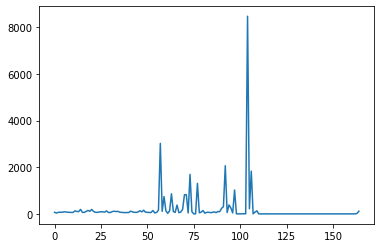

In [118]:
import matplotlib.pyplot as plt
plotting_values = []
for d in data_values:
    plotting_values.append(d['y'])
plt.plot(range(len(plotting_values)), plotting_values)